# CA4015 Recommender System Assignment
**Author:** Joseph Oluwasanya  
**StudentID:** 19329261

In this assignment, I build a system for recommending users to artists based on their listening history. The music library used is the Last.FM dataset, consisting of 92,800 artist listening records from 1892 users.
<br>
### Table of Contents:
1. **Data Preperation**: Packages and datasets are imported. Data analysis and prepreocessing code is included here.  
    1.1 Importing Packages  
    1.2 Data Analysis  
    1.3 Data Preprocessing

2. **Recommender System**: Building, testing, and evaluating the recommender system  
    2.1 Building CF Model  
3. **Evaluating Recommendations:** Testing is split into two sections. User recommendations, and embedding nearest neighbors.  
    3.1 Your recommendations  
    3.2 Embeddings Nearest neighbors 




## 1. Data Preparation

### 1.1 Importing Packages

In [1]:
import pandas as pd
import numpy as np
import collections
from IPython import display

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() # Disable eager evaluations
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# convenience functions for pandas dataframe
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

# filters dataframe using 'function' applied to' key' column
def mask(df, key, function):
    return df[function(df[key])]

# flattens multi-indexed columns
def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]


pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

seed=42
%matplotlib inline


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
artists = pd.read_csv('data/artists.dat', delimiter='\t')
artists = artists.rename(columns={'id': 'artistID'})
user_artists = pd.read_csv('data/user_artists.dat', delimiter='\t')
user_friends = pd.read_csv('data/user_friends.dat', delimiter='\t')
user_tagged = pd.read_csv('data/user_taggedartists.dat', delimiter='\t')
user_tagged_timestamp = pd.read_csv('data/user_taggedartists-timestamps.dat', delimiter='\t')


In [3]:
# utf-8 (default) encoding failed to decode, so switched to latin1
tags = pd.read_csv('data/tags.dat', delimiter='\t', encoding='latin1')


In [4]:
datasets = [artists, user_artists, user_friends, user_tagged]

In [5]:
print(tags.shape)
tags.head()

(11946, 2)


,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [6]:
print(artists.shape)
artists.head()

(17632, 4)


,artistID,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [7]:
print(user_artists.shape)
user_artists.head()

(92834, 3)


,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [8]:
print(user_friends.shape)
user_friends.head()

(25434, 2)


,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [9]:
print(user_tagged.shape)
user_tagged.head()

(186479, 6)


,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [10]:
print(user_tagged_timestamp.shape)
user_tagged_timestamp.head()

(186479, 4)


,userID,artistID,tagID,timestamp
0,2,52,13,1238536800000
1,2,52,15,1238536800000
2,2,52,18,1238536800000
3,2,52,21,1238536800000
4,2,52,41,1238536800000


### 1.2 Data Analysis

The following tables are featured in the dataset:  
**artist:** Contains map of artistID to artist name and URLs to their music on last.fm, and a picture of them.

**user_artist:** Contains the entries for producing sparse feedback matrix of listeners and artists. That is, user-artist pairs with a "listening count" under the name "weight". From exploring this weights variable, I saw that it doesn't lend itself well to a 5-star rating manual feedback representation but rather an implicit feedback representation.

**user_tagged**: Users were able to assign tags to artists. These are stored here in (userID, tagID) pairs. The timestamp at which the tags were assigned are also included (may not use those). I will add a "top3 tags" and "top1 tag" as additional information to the data. This will help with evaluating the recommendations later. 

**user_friends**: Contains (user, friend) relationships by userID



In [11]:
def missing_vals(df):
    return df.isna().sum()

for df in datasets:
    print(missing_vals(df))
    print("-"*30)


artistID        0
name            0
url             0
pictureURL    444
dtype: int64
------------------------------
userID      0
artistID    0
weight      0
dtype: int64
------------------------------
userID      0
friendID    0
dtype: int64
------------------------------
userID      0
artistID    0
tagID       0
day         0
month       0
year        0
dtype: int64
------------------------------


Values for the weight variable have a wide range. There are extreme outliers that will impact the recommender negatively by dominating the embedding matrix optimisation. First I remove the rows with weights exceeding the 95th percentile, and then scale the weights into the range [0, 1]. A non-zero weight implies the user listened to the artist and the higher the value, the more the user listened to the artist.

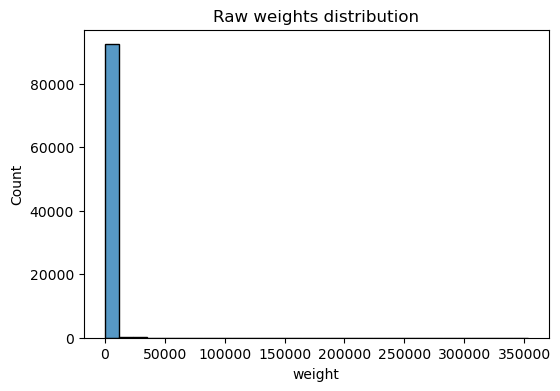

count    92834.000
mean       745.244
std       3751.322
min          1.000
25%        107.000
50%        260.000
75%        614.000
max     352698.000
Name: weight, dtype: float64


In [12]:
# check distribution of weights variable
plt.figure(figsize=(6, 4))
sns.histplot(user_artists['weight'], bins=30)
plt.title("Raw weights distribution")
plt.show()
print(user_artists.weight.describe())


In [13]:
np.quantile(user_artists.weight, .99)

7228.009999999995

In [14]:
# remove outliers from dataset
q_outliers = user_artists.loc[user_artists.weight > np.quantile(user_artists.weight, .99)].weight
user_artists_aux = user_artists.copy()
user_artists_aux = user_artists_aux.loc[~(user_artists_aux.weight.isin(q_outliers)), :]

print("Rows removed:", user_artists.shape[0] - user_artists_aux.shape[0])

Rows removed: 929


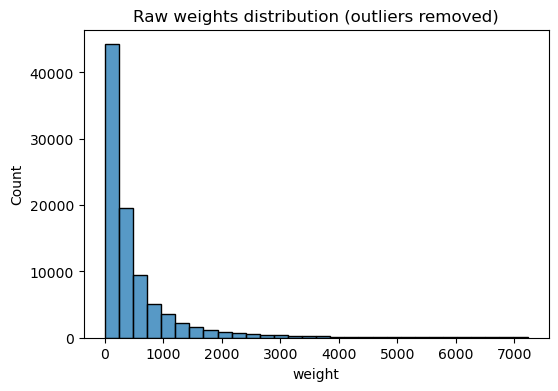

count   91905.000
mean      536.547
std       823.351
min         1.000
25%       106.000
50%       256.000
75%       595.000
max      7226.000
Name: weight, dtype: float64


In [15]:
# check distribution of weights with outliers removed
plt.figure(figsize=(6, 4))

sns.histplot(user_artists_aux['weight'], bins=30)
plt.title("Raw weights distribution (outliers removed)")
plt.show()
print(user_artists_aux.weight.describe())


In [16]:
# scale the weights into the [0, 1] range
mm = MinMaxScaler()
user_artists_aux['w_mm'] = mm.fit_transform(user_artists_aux['weight'].to_frame())
user_artists_aux.w_mm.describe()

count   91905.000
mean        0.074
std         0.114
min         0.000
25%         0.015
50%         0.035
75%         0.082
max         1.000
Name: w_mm, dtype: float64

As can be seen below, the average weighting of artists for different users was right skewed with extreme outliers before the outlier removal.

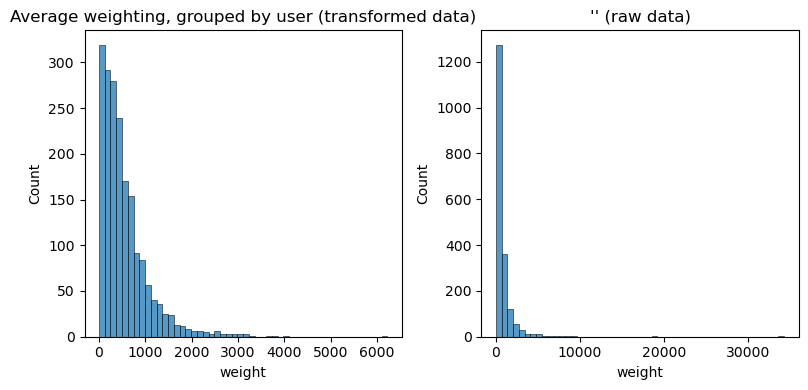

In [17]:
# check distribution of mean weights in user_artist data
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
user_mean_weights = user_artists_aux.groupby('userID')['weight'].mean()
user_mean_weights_prev = user_artists.groupby('userID')['weight'].mean()

sns.histplot(user_mean_weights, bins=50, ax=axs[0])
sns.histplot(user_mean_weights_prev, bins=50, ax=axs[1])

axs[0].set(title="Average weighting, grouped by user (transformed data)")
axs[1].set(title="'' (raw data)")

plt.tight_layout()

plt.show()


In [18]:
user_artists_aux[['weight', 'w_mm']].describe()

,weight,w_mm
count,91905.000,91905.000
mean,536.547,0.074
std,823.351,0.114
min,1.000,0.000
25%,106.000,0.015
50%,256.000,0.035
75%,595.000,0.082
max,7226.000,1.000


In [19]:
# create new userID and artistID identifiers for the transformed user_artists matrix
old_user_id = user_artists['userID'].sort_values().unique()
old_artist_id = user_artists['artistID'].sort_values().unique()
new_user_id = np.array([i for i in range(len(old_user_id))])
new_artist_id = np.array([i for i in range(len(old_artist_id))])

u_id_map = {old: new for old, new in zip(old_user_id, new_user_id)}
a_id_map = {old: new for old, new in zip(old_artist_id, new_artist_id)}

user_artists['u_id'] = user_artists.userID.map(u_id_map).astype(int)
user_artists['a_id'] = user_artists.artistID.map(a_id_map).astype(int)
artists['a_id'] = artists.artistID.map(a_id_map).astype(int)
artists = artists.sort_values('a_id')


Popularity score testing

In [20]:
# popularity_score = sum of artist weights divided by the number of users in the dataset
# listeners = simple listener count for the artists

n_users = user_artists.u_id.unique().shape[0]

artist_listeners = user_artists.groupby('a_id').agg(
popularity_score=('weight', lambda x: (x.sum() / n_users)), 
listeners=('weight', lambda x: (x > 0).sum())).reset_index()

artist_listeners = artist_listeners.merge(artists[['a_id', 'name']],how='left', on='a_id')


In [21]:
# top ten artists with the most listeners
# there is a strong overlap between artists with the most listening time (popularity) and most listeners, as expected
k=10
artist_listeners.sort_values('popularity_score', ascending=False).head(k)

,a_id,popularity_score,listeners,name
283,283,1264.873,522,Britney Spears
66,66,687.795,282,Depeche Mode
83,83,682.551,611,Lady Gaga
286,286,559.411,407,Christina Aguilera
492,492,509.223,399,Paramore
61,61,486.891,429,Madonna
282,282,478.553,484,Rihanna
695,695,363.916,319,Shakira
221,221,349.956,480,The Beatles
294,294,281.472,473,Katy Perry


The plot and descriptive statistics below show that most artists have very few listeners in the dataset (over half have 1 listener in fact).

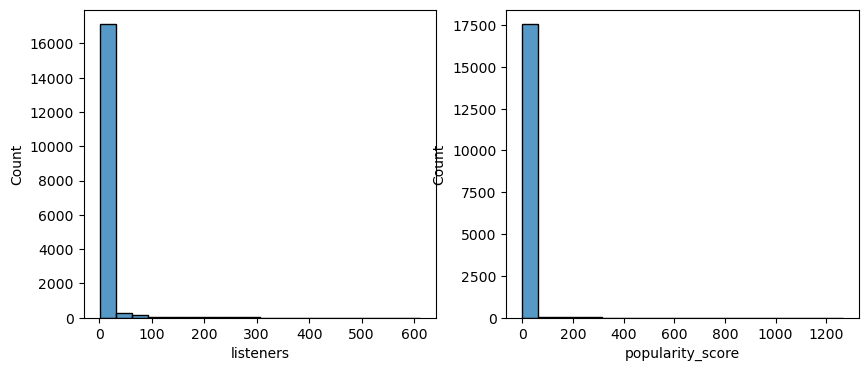

       popularity_score  listeners
count         17632.000  17632.000
mean              2.074      5.265
std              18.023     20.620
min               0.001      1.000
25%               0.060      1.000
50%               0.185      1.000
75%               0.652      3.000
max            1264.873    611.000


In [22]:
# distribution of listener counts and popularity scores
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(x='listeners', data=artist_listeners, ax=axs[0], bins=20)
sns.histplot(x='popularity_score', data=artist_listeners, ax=axs[1], bins=20)
plt.show()
print(artist_listeners[['popularity_score', 'listeners']].describe())


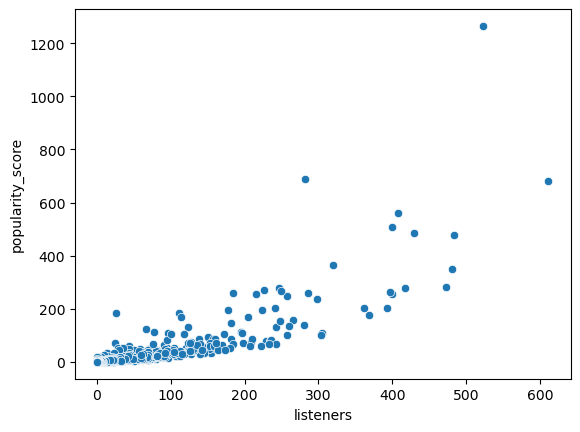

In [23]:
# positive correlation between listeners and popularity score, with extreme outliers
sns.scatterplot(x='listeners', y='popularity_score', data=artist_listeners)
plt.show()

### 1.3 Data Preprocessing

Preprocessing steps:
- Removed ratings higher than the 99th percentile.

- Scaled weights (implicit ratings) to the range [0, 1].  

- Add top3_tags and top1_tags columns to the artists dataset. Found that the tags often give additional information about artists' genres.

- Created new index columns a_id, and u_id for use after outlier removal. Ensures that u_id starts at 0 and ends at n_users - 1. The equivalent was done for artists.

- Added popularity score and listener cound columns to artists. This helps to check the models predictions for popularity bias, and also to provide a reasonable list of artists for you to choose from in Section 2.3.1 Your Recommendations. The basis for the popularity score is that we should consider both the number of listeners and listening quantity when quantifying popularity.  
<br>*popularity_score = sum of artist weights / n_users*  
*listeners = # listeners for the artist*

- DataFrame split method to calculate test (generalization) error.

Removing outliers and scaling the weights. Note that after outlier removal the popularity scores will differ from the earlier testing

In [24]:
def transform_weights(user_artists=user_artists, remove_outliers=True, quantile=0.99):
    '''
    Strip outliers and apply minmax scaler to the weights column of the user_artists table

    Args:
        user_artists: name of the user_artists pandas dataframe. Defaults to user_artists. 
    '''
    
    user_artists = user_artists.copy()

    if remove_outliers:
        # Remove outliers (95th Percentile)
        q_outllier = user_artists.loc[user_artists.weight > np.quantile(user_artists.weight, quantile)].weight
        user_artists_aux = user_artists.copy()
        user_artists = user_artists.loc[~(user_artists.weight.isin(q_outllier)), :]

        print("Rows removed:", user_artists_aux.shape[0] - user_artists.shape[0])
    
    # scale the weight to [0, 1]
    mm = MinMaxScaler()
    mm.fit_transform(user_artists.weight.to_frame())
    user_artists['w_mm'] = mm.fit_transform(user_artists['weight'].to_frame())

    return user_artists

user_artists = transform_weights(user_artists)

Rows removed: 929


In [25]:
user_artists.head()

,userID,artistID,weight,u_id,a_id,w_mm
5,2,56,6152,0,50,0.851
6,2,57,5955,0,51,0.824
7,2,58,4616,0,52,0.639
8,2,59,4337,0,53,0.600
9,2,60,4147,0,54,0.574


In [26]:
# tag column joins tagValues into the user_tagged table
user_tagged['tag'] = user_tagged.merge(tags, on='tagID')['tagValue']

# add artist names to tag table
user_tagged['artist_name'] = user_tagged.merge(artists, on='artistID', how='left')['name']

# drop tags which are referring to an artist that doesn't exist in the artist table
pre_drop = user_tagged.shape[0]
user_tagged = user_tagged.dropna()
print("Dropped", pre_drop - user_tagged.shape[0], "rows in tags dataset")
print(user_tagged.shape)

Dropped 1538 rows in tags dataset
(184941, 8)


In [27]:
# users assign tags to artists, these seem to often provide tag information
# more rarely, they contain individual user comments that are less useful to us.
print("Top 5 tags")
print(user_tagged.tag.value_counts()[:5])
print("-"*30)
print("Bottom 5 tags")
print(user_tagged.tag.value_counts()[-5:])


Top 5 tags
rock           7431
pop            5393
alternative    5224
electronic     4638
indie          4396
Name: tag, dtype: int64
------------------------------
Bottom 5 tags
mairead nesbitt       1
sad and beautifull    1
michelle williams     1
sugababes             1
love gaga             1
Name: tag, dtype: int64


In [28]:
# create "tags" column in user_artist with the top 3 most popular tags given to an artist
tag_occurences = user_tagged.groupby(['artistID', 'artist_name', 'tag'])['tagID'].count().reset_index()
tag_occurences = tag_occurences.rename(columns={'tagID':'tag_count'})

# within each artistID partition, sort by tag_count
tag_occurences = tag_occurences.sort_values(['artistID', 'tag_count'], ascending=[True, False])


In [29]:
tag_occurences.loc[tag_occurences['artistID'] == 1000][:10]

,artistID,artist_name,tag,tag_count
20388,1000,Information Society,tyler adam,12
20384,1000,Information Society,love,11
20381,1000,Information Society,french,7
20379,1000,Information Society,chillout,4
20385,1000,Information Society,melancholic,4
20375,1000,Information Society,ambient,3
20378,1000,Information Society,beautiful,2
20380,1000,Information Society,dance,2
20382,1000,Information Society,hard rock,2
20374,1000,Information Society,80s,1


In [30]:
# testing the behaviour we want for the top3 and top1 tag columns
for id in tag_occurences.artistID.unique()[:5]:
    top3_tags = " / ".join(tag_occurences.loc[tag_occurences.artistID == id]['tag'].values[:3])
    top1_tags = tag_occurences.loc[tag_occurences.artistID == id]['tag'].values[0]
    
    print("Top tag for", tag_occurences.loc[tag_occurences.artistID == id]['artist_name'].values[0], "=", top1_tags)
    print(top3_tags)
    print("-"*30)



Top tag for MALICE MIZER = cybergrind
cybergrind / fucking awesome / german
------------------------------
Top tag for Diary of Dreams = top 40
top 40 / art rock / electronic
------------------------------
Top tag for Carpathian Forest = jazz
jazz / christian metal / ambient
------------------------------
Top tag for Moi dix Mois = fucking awesome
fucking awesome / cybergrind / art rock
------------------------------
Top tag for Bella Morte = summer
summer / acoustic / aphex twin
------------------------------


In [31]:
# for each artist, get the top 3 tags and top 1 tags. add this to artists information

def add_top_tags(df, artistID='artistID'):
    '''
    Add top3_tags and top_1 tags to table. Works only if the input table has an artistID column.
   
    Args:
        df: pandas dataframe to append the tags information onto.
        artistID: The artistID column name in the dataset. Defaults to 'artistID'
    '''
    df = df.copy()

    if artistID not in df.columns.tolist():
        raise KeyError(artistID, "column not present in the input table")

    # new table with (artist, tagValue, tag_count) information
    tag_occurences = user_tagged.groupby(['artistID', 'artist_name', 'tag'])['tagID'].count().reset_index()
    tag_occurences = tag_occurences.rename(columns={'tagID':'tag_count'})

    # within each artistID partition, sort by tag_count
    tag_occurences = tag_occurences.sort_values(['artistID', 'tag_count'], ascending=[True, False])

    tag_occurences['top3_tags'] = np.zeros(tag_occurences.shape[0])
    tag_occurences['top1_tags'] = np.zeros(tag_occurences.shape[0])

    for id in tag_occurences.artistID.unique():
        top3_tags = " / ".join(tag_occurences.loc[tag_occurences.artistID == id]['tag'].values[:3])
        top1_tags = tag_occurences.loc[tag_occurences.artistID == id]['tag'].values[0]

        # add top3 and top1 tags information to artists table
        df.loc[df.artistID == id, ['top3_tags', 'top1_tags']] = [top3_tags, top1_tags]
    
    df['top3_tags'] = df.top3_tags.fillna("none")
    df['top1_tags'] = df.top1_tags.fillna("none")

    return df

artists = add_top_tags(artists)

In [32]:
artists.head()

,artistID,name,url,pictureURL,a_id,top3_tags,top1_tags
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0,cybergrind / fucking awesome / german,cybergrind
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,1,top 40 / art rock / electronic,top 40
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...,2,jazz / christian metal / ambient,jazz
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...,3,fucking awesome / cybergrind / art rock,fucking awesome
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...,4,summer / acoustic / aphex twin,summer


In [33]:
# Not all artists have tags; these have missing values for the tag variables
# not all artists have up to 3 unique tags
artists.loc[artists.artistID == 18742]

,artistID,name,url,pictureURL,a_id,top3_tags,top1_tags
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg,17628,none,none


In [34]:
# some artists have less than 3 unique tags. In this case the top 2 or 1 tags is stored as "top3_tags"
artists.loc[artists.artistID == 18741]

,artistID,name,url,pictureURL,a_id,top3_tags,top1_tags
17627,18741,Diamanda Galás,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...,17627,eldad / rock hard,eldad


In [35]:
print("artists: {}, listened artists: {}".format(artists.shape[0], user_artists.artistID.unique().shape[0]))

# remove artists with no listens from the dataset (these are redundant for collaborative filtering)
artists = artists.loc[artists['artistID'].isin(user_artists.artistID.unique())]
print("removed artist with no listens from dataset")

artists: 17632, listened artists: 17608
removed artist with no listens from dataset


In [36]:
# create new userID and artistID identifiers for the transformed user_artists matrix
old_user_id = user_artists['userID'].sort_values().unique()
old_artist_id = user_artists['artistID'].sort_values().unique()
new_user_id = np.array([i for i in range(len(old_user_id))])
new_artist_id = np.array([i for i in range(len(old_artist_id))])

u_id_map = {old: new for old, new in zip(old_user_id, new_user_id)}
a_id_map = {old: new for old, new in zip(old_artist_id, new_artist_id)}

user_artists['u_id'] = user_artists.userID.map(u_id_map).astype(int)
user_artists['a_id'] = user_artists.artistID.map(a_id_map).astype(int)
artists['a_id'] = artists.artistID.map(a_id_map).astype(int)
artists = artists.sort_values('a_id')


In [37]:
# checking the behaviour of new id columns
user_artists.sort_values("a_id")

,userID,artistID,weight,u_id,a_id,w_mm
35861,785,1,76,729,0,0.010
1550,34,1,212,31,0,0.029
12611,274,1,483,256,0,0.067
42401,935,2,428,862,1,0.059
26690,580,2,803,542,1,0.111
...,...,...,...,...,...,...
20914,454,18741,301,423,17603,0.042
20915,454,18742,294,423,17604,0.041
20916,454,18743,287,423,17605,0.040
20917,454,18744,286,423,17606,0.039


In [38]:
def add_popularity_score(df):
    '''
        Add popularity score and listener count to the dataset
        popularity_score = sum of artist weights / n_users
    '''
    df = df.copy()
    n_users = user_artists.u_id.unique().shape[0]

    artist_listeners = user_artists.groupby('a_id').agg(
    popularity_score=('weight', lambda x: (x.sum() / n_users)), 
    listeners=('weight', lambda x: (x > 0).sum())).reset_index().sort_values('a_id')
    
    df = df.merge(artist_listeners[['a_id', 'popularity_score', 'listeners']], on='a_id', how='left')

    return df

artists = add_popularity_score(artists)

In [39]:
a_to_check = artists.sort_values('popularity_score', ascending=False).loc[:, ['a_id', 'name', 'listeners', 'popularity_score']]

In [40]:
# popularity_score = sum of artist weights divided by the number of users in the dataset
# listeners = simple listener count for the artists

n_users = user_artists.userID.unique().shape[0]

artist_listeners = user_artists.groupby('a_id').agg(
    popularity_score=('weight', lambda x: (x.sum() / n_users)), 
    listeners=('weight', lambda x: (x > 0).sum())).reset_index().sort_values('a_id')

artist_listeners['name'] = artist_listeners.merge(artists,how='left', on='a_id')['name']


In [41]:
# validating the popularity score function.
al_to_check = artist_listeners.loc[:, ['a_id', 'name', 'listeners', 'popularity_score']].sort_values('popularity_score', ascending=False)
all(al_to_check == a_to_check)

True

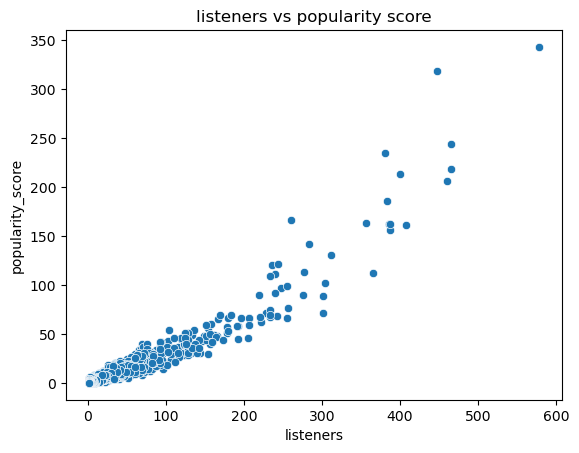

In [42]:
sns.scatterplot(x='listeners', y='popularity_score', data=artists)
plt.title('listeners vs popularity score')
plt.show()

In [43]:
# We will use this to check the generalisation error of CFmodel when we hide a small proportion of ratings.

def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

## 2. Recommender System

**Collaborative filter approach:** Based on the listening histories of users in user_artists, A sparse rating matrix $A$ of dimension ($N \times M$) is constructed. Using this, a latent factor collaborative filtering model is built. Matrix factorisation is used to create embedding matrices $U$ and $V$ which approximate the rating matrix. Matrix $U$, of shape $(N, k)$ holds k-dimensional user_embeddings for each of the $N$ users. Matrix $V$ Holds k-dimensional artist embeddings for each of the $M$ artists in user_artists.

Using these embedding matrices rather than the rating matrix itself, the CF model computes similarities between user and item embeddings in the embedding space, which is cheaper than computing similarities between users by using the raw rating matrix. We rank these similarities and return the top k results as recommendations to the user.

To test the recommender system on unseen examples (such as your own listening preferences), I developed a heuristic for approximating the user embedding vector for new users. More on this in **section 2.3.1 (Testing Recommendations, Your Recommendations)**, where you have the option to add your own artist preferences and recieve recommendations.



### 2.1 Building CF model

This section contains all the functions required for building and running the recommendation system. It can be run all at once

In [44]:
# build sparse rating tensor out of the user_artists weight information
n_users = len(user_artists.u_id.unique())
n_artists = artists.shape[0]
def build_rating_sparse_tensor(ratings:pd.DataFrame = user_artists):
    '''
        Create N X M sparse rating matrix, where N is number of users and M is number of artists.
        Args:
            ratings: a pd.DataFrame with 'u_id', 'a_id', and implicit rating column ('w_mm').
        Returns:
            A tf.SparseTensor representing ratings matrix.
    '''
    indices = ratings[['u_id', 'a_id']].values
    values = ratings['w_mm'].values
    return tf.SparseTensor(indices=indices, values=values, dense_shape=[n_users, n_artists])

In [45]:
[n_users, n_artists]

[1891, 17608]

In [46]:
# Sparse tensor to represent the user_artist listening matrix
sparse_ratings = build_rating_sparse_tensor(user_artists)

In the function below we compute the mean square error between the observed values in rating matrix $A$ and the embedding matrices $U$ and $V$. This is calculated as follows:

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings (listeners), and $|\Omega|$ is the cardinality of $\Omega$.


In [47]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, artist_embeddings):
    '''
    Compute the mean square error between UV.T and sparse rating matrix
    
    Args:
        sparse_ratings: SparseTensor of rating matrix, dense shape [N, M]
        user_embeddings: Dense Tensor U of shape [N, k] where k is embedding dimension, such that U_i is the embedding of user i
        artist_embeddings: A dense Tensor V of shape [M, k] where k is the embedding dimension, such that V_j is the embedding of artist j.
    
    Returns:
        A scalar Tensor representing the MSE between the true ratings and the
        model's predictions.

    '''

    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(artist_embeddings, sparse_ratings.indices[:, 1]),
        axis=1)
    
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

In [48]:
# Sparse tensor to represent the user_artist listening matrix
sparse_ratings = build_rating_sparse_tensor(user_artists)

Class to train a matrix factorisation model using stochastic gradient descent to optimise parameters:

In [49]:
class CFModel(object):
    '''Represents a collaborative filtering model'''

    def __init__(self, embedding_vars, loss, metrics=None):
        '''Initialise a CFModel instance
        Args:
            embedding_vars: dictionary of tf.Variables
            loss: The loss to optimise. Tensor containing a single float value
            metrics: optional list of dictionaries of Tensors. The metrics in each dicitonary will be plotted in a separate figure during training.
        '''
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session=None

    @property
    def embeddings(self):
        '''Return embeddings dictionary'''
        return self._embeddings
    
    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True, optimizer=tf.train.GradientDescentOptimizer):
        '''Trains the model, tuning the embeddings to approximate feedback matrix
        Args:
            iterations: the number of iterations to run. More iterations will take longer but can further minimise the loss.
            learning_rate: optimizer learning rate.
            plot_results (boolean): whether to plot results after training.
            optimzer: the optimizer to use. Default to Gradient Descent

            Returns:
                the metrics dictionary evaluated at the last iteration.
        '''
        # session set up
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()
        
        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append the results
            for i in tqdm(range(num_iterations + 1)):
                _, results = self._session.run((train_op, metrics))
                if (i % 100 == 0) or i == num_iterations:
                    #print("\r iteration %d: " % i + ", ".join(["%s=%f" % (k, v) for r in results for k, v in r.items()]))
                    
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)
            
            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()
            
            if plot_results:
                # Plot the metrics
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metrics_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metrics_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            
            return results

The function below builds a CFModel by initialising the embedding variables and the losses, and feeding these to CFModel class. The CFModel adjusts the user and artist embedding values so as to minimize the objective function this optimisation is carried out using the Stochastic Gradient Descent algorithm.

Mean Square Error of the observed values, regularization using a gravity term and L2 regularization terms are incorporated into the objective function. Regularisation terms ensure that the model doesn't just fit the observed part of the rating matrix (the relevant artists), but also learns to score the unrated artists by the user as well.

- L2 regularisaiton of the embeddings is given by:
$r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.

- gravity, a global prior that pushes all the predictions towards zero, is given by:
$g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

Hence, the objective function is given by 
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients, and should be tuned as hyper-parameters. $\Omega$ is the set of observed ratings. Note that average rating is so close to zero already; for this reason the default value for gravity coefficient is 0.

In [50]:
mean_rating = tf.Session().run(tf.reduce_mean(tf.sparse.to_dense(sparse_ratings)))
mean_rating

0.00020459619354275211

In [51]:
def gravity(U, V):
    '''Creates gravity loss from two embedding matrices.'''
    return 1/(U.shape[0].value * V.shape[0].value) * tf.reduce_sum(
        tf.matmul(U, U, transpose_a = True) * tf.matmul(V, V, transpose_a=True))

def build_model(ratings, embedding_dim=3, regularization_coeff=1., gravity_coeff=0, init_stddev=1.):
    '''
    Args:
        ratings: a Dataframe of ratings; entries for rating matrix.
        embedding_dim: dimension of embedding vectors.
        regularization_coeff: L2 regularisation coefficient lambda_r.
        gravity_coeff: Gravity regularization coefficient lambda_g.
        init_stddev: float, standard deviation of the random initial embeddings.
    Returns:
        model: a CFModel object.
    '''
    # split the ratings DataFrame into train and test
    # the sparse matrices will have the same dimensionality for train and test, 
    # but test values are set to 0 in train_ratings and vice versa
    train_ratings, test_ratings = split_dataframe(ratings)
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)

    # initialise embeddings using normal distribution
    U = tf.Variable(tf.random_normal([A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal([A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

    error_train = sparse_mean_square_error(A_train, U, V)
    error_test = sparse_mean_square_error(A_test, U, V)
    gravity_loss = gravity_coeff * gravity(U, V)
    regularization_loss = regularization_coeff * (
        tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)

    total_loss = error_train + regularization_loss + gravity_loss

    losses = {
        'train_error_observed': error_train,
        'test_error_observed': error_test
    }
    loss_components = {
        'observed_loss': error_train,
        'regularization_loss': regularization_loss,
        'gravity_loss': gravity_loss
    }
    embeddings={
        "u_id": U,
        "a_id": V
    }
    return CFModel(embeddings, total_loss, [losses, loss_components])

In [52]:
def compute_scores(user_embedding, item_embeddings, measure='dot'):
  """Computes the scores for the artists given a user's listening history
  Args:
    user_embedding: k-dimensional vector representing the user embedding.
    item_embeddings: matrix of shape [N, k], such that row i is the embedding
    of artist/item i.
    measure: a string specifying the similarity measure to be used. Can be
      either 'dot' or 'cosine'
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  # ========================= Complete this section ============================
  
  u = user_embedding
  V = item_embeddings

  # if meaure is cosine, then we normalize the query vector and item matrix before computing the dot product
  if measure == 'cosine':
    u = user_embedding / np.linalg.norm(u)
    V = item_embeddings / np.linalg.norm(V, axis=1, keepdims=True)    
  
  scores = np.dot(u, V.T)
  # ============================================================================
  return scores

In [53]:
# User recommendations using user embedding approximation
def user_recommendations(model, user_rec_embedding, measure='dot', exclude_rated=False, k=6):
    ''' Get artist recommendations for a given user embedding vector 
        Args:
            model: CFModel for producing recommendations
            user_rec_embedding: k-dimensional numpy array representing user recommendaiton embedding. k is embedding dimensionality.
            measure: similarity measure to use for recommendaitons ('dot' or 'cosine')
            exclude_rated: whether to exclude artists that are already listened by user
            k: number of artists to recommend. 
        
        Returns:    
        top k most similar artist embeddings to our user embedding in terms of 'measure'
            
            '''
    scores = compute_scores(
        user_rec_embedding, model.embeddings['a_id'], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'artist name': artists['name'],
        'top3 tags': artists['top3_tags'],
        'popularity_score': artists['popularity_score'],
        'listeners': artists['listeners']
    })
    if exclude_rated:
      # remove artists that are already listened to
      rated_artists = user_like.a_id.values
      df = df[df.a_id.apply(lambda a_id: a_id not in rated_artists)]
    display.display(df.sort_values([score_key], ascending=False).head(k)) 

    return df;

In [54]:
def artist_neighbors(model, name_substring, measure='dot', k=5):
    '''
        find the k nearest neighbors to artist embedding in the embedding space
        Args:
            model: Collaborative filter model
            name_substring: artist name to search for
            measure: similarity measure ('dot' or 'cosine')
            k: number of neighbors to return

    '''
    # Search for artist id's that match the substring
    ids = artists[artists['name'].str.contains(name_substring)]['a_id'].values
    names = artists.loc[artists['a_id'].isin(ids), 'name'].values

    if len(names) == 0:
        raise ValueError("Didn't find artists with title {}".format(name_substring))

    print('Nearest neighbors of: {}'.format(names[0]))
    if len(names) > 1:
        print("Found several artists matching the search. Other candidates: {}".format(", ".join(names[1:])))
    
    artist_id = ids[0]
    scores = compute_scores(model.embeddings['a_id'][artist_id], model.embeddings['a_id'], 
measure)
    score_key = measure + ' score'
    

    df = pd.DataFrame({
        score_key: list(scores),
        'artist': artists['name'],
        'top3_tags': artists['top3_tags'],
        'popularity_score': artists['popularity_score'],
        'listeners': artists['listeners']
    })
    display.display(df.sort_values([score_key], ascending=False).iloc[:, :].head(k))

    return df;


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


100%|██████████| 2001/2001 [00:13<00:00, 144.37it/s]


[{'train_error_observed': 0.36004344, 'test_error_observed': 1.1416062}, {'observed_loss': 0.36004344, 'regularization_loss': 0.0, 'gravity_loss': 0.0}]


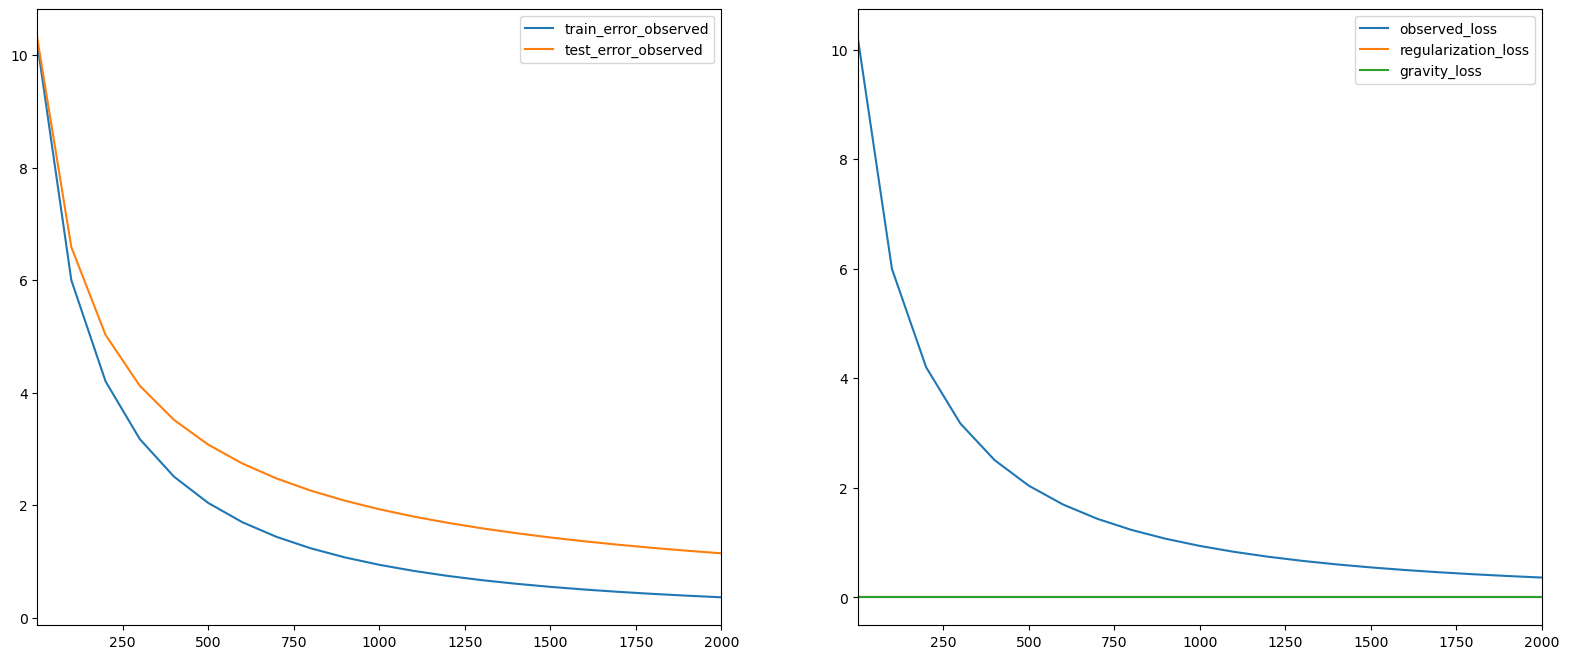

In [55]:
model0 = build_model(user_artists, embedding_dim=10, regularization_coeff=0, gravity_coeff=0, init_stddev=1)
results0 = model0.train(num_iterations=2000)
print(results0)

In [56]:
total_loss = 0
for k, v in results0[1].items():
    total_loss += v

print('total_loss: {}'.format(np.round(total_loss, 4)))

total_loss: 0.36


Suitable hyperparameters (Embedding dimensionality, regularization coefficients, and embedding initialisation variance)
were found by hand-tuning the parameters, and checking the nearest neighbors and personal recommendations at each step. I did this because I found that minimising the total error does not pertain to better predictions, so subjective judgement is required.

For example, increasing the gravity coefficient pushes all predictions further towards 0 which reduces the total_error. And increasing the L2 regularization coefficient increases the total error, so a cross validation search favors models with lower L2 regularization coefficients. 

100%|██████████| 2001/2001 [00:14<00:00, 136.21it/s]


[{'train_error_observed': 0.04508776, 'test_error_observed': 0.09184611}, {'observed_loss': 0.04508776, 'regularization_loss': 1.695413, 'gravity_loss': 0.06439318}]


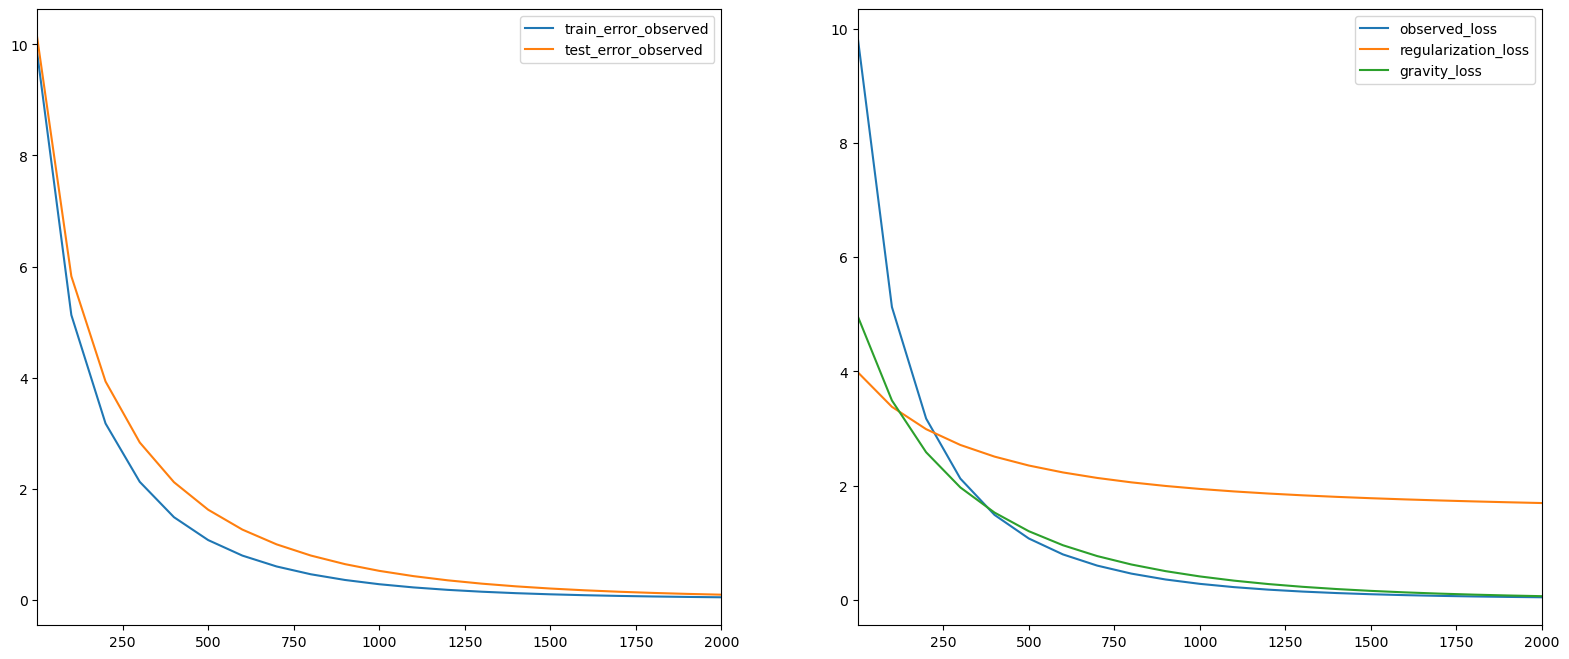

In [57]:
model = build_model(user_artists, embedding_dim=10, regularization_coeff=0.2, gravity_coeff=0.5, init_stddev=1)
results = model.train(num_iterations=2000)
print(results)

In [58]:
total_loss = 0
for k, v in results[1].items():
    total_loss += v

print('total_loss: {}'.format(np.round(total_loss, 4)))

total_loss: 1.8049


### 3. Evaluating Recommendations

In the following sections the CF model constructed in Section 2 is evaluated using recommendations based on your artist preferences (demonstrating the model's ability to produce recommendations for unseen queries), as well as checking nearest neighbors of artists in the embedding space.

#### 3.1 Your Recommendations

**Action:** To produce recommendations based on your own artist preferences, please follow the steps below.

1. Open "your_artists.csv".

2. Inspect the list of the top 250 artists in terms of listener count in the last.FM dataset.

3. **For artists that you enjoy listening to, Put a number 1 in the "Like column (Column B) beside their name". Leave the rest blank.**

4. Save and close the file.

<br>

This is how your recommendations are calculated:
1. First a sparse vector with your preferences encoded is created from the "your_artists.csv" file.
2. Dot product similarity between the sparse vector and the other user vectors in the ratings matrix are then computed.
3. The top 5 similar users' embeddings are averaged.
4. The output is multiplied by the artist embeddings matrix to get recommendations.

There are different ways to calculate recommendations for new users, but I came up with this heuristic under the assumption that users with similar preferences to you exist in the dataset already, so applying some combination of their user vectors should yield relevant recommendations.

In [59]:
# Reset the 'your_artists.csv' file
#artists.sort_values('listeners', ascending=False)['name'].head(250).to_csv('your_artists.csv', index=False)

**set user_rating_bool to false if you don't want to provide recommendations.** In that case the recommender will be tested on my own preferences


In [ ]:
user_rating_bool=True

In [60]:
if user_rating_bool:
    user_pref = pd.read_csv('your_artists.csv')
else:
    user_pref = pd.read_csv('joseph_artists.csv')


print("Artists you like:")
user_pref.loc[user_pref['Like'] == 1, ['name']]


Artists you like:


,name
0,Lady Gaga
3,Rihanna
6,Beyoncé
77,Kanye West
128,Justin Bieber
143,Usher
162,Nicki Minaj
170,Chris Brown


In [61]:
def get_similar_users(user_vec):
    '''get dot product similarity scores between user vector and each user in the ratings matrix '''
    
    u = user_vec
    V = sparse_ratings
    
    scores = tf.sparse.sparse_dense_matmul(V, u,)
    return scores

In [62]:
# create sparse user vector from user preferences
user_like = user_pref.loc[user_pref['Like'] == 1, ['name']]
user_like = user_like.merge(artists[['name', 'a_id']], on='name', how='left').sort_values('a_id')

user_vec = tf.sparse.SparseTensor(
    indices=[[ind] for ind in user_like.a_id], 
    values = np.ones(shape=user_like.shape[0]), 
    dense_shape = [artists.shape[0]])

# convert to dense tensor for matrix multiplication
user_vec = tf.sparse.to_dense(user_vec)
user_vec = tf.expand_dims(user_vec, 1)

# compile the user vectors of the most similar users into a list
n_u_mean = 5
scores = tf.Session().run(get_similar_users(user_vec))
sim_df = pd.DataFrame({'u_id':user_artists.u_id.unique(), 'score': scores.flatten()})
similar_users = sim_df.sort_values('score', ascending=False).head(n_u_mean)

In [63]:
# Validating the user similarity calculation.
similar_users_common = user_artists.loc[(user_artists.u_id.isin(similar_users.u_id)) & (user_artists.a_id.isin(user_like.a_id)), \
    ['a_id']] \
    .merge(artists[['a_id', 'artistID', 'top1_tags', 'name']], on='a_id', how='left')[['name', 'top1_tags']]

print("Users with similar preferences to you listened to the following artists in common with you:")
tags_to_check = similar_users_common.top1_tags.unique()
similar_users_common.drop_duplicates()

Users with similar preferences to you listened to the following artists in common with you:


,name,top1_tags
0,Lady Gaga,alternative
1,Rihanna,electronic
2,Beyoncé,hard rock
3,Kanye West,gothic rock
4,Justin Bieber,female vocalists
5,Usher,female vocalists
14,Nicki Minaj,electronic
18,Chris Brown,female vocalists


Note the top tags for the artists above. We will check that the recommendations contain some similar tags.

In [64]:
# mean of the similar users embeddings is used to approximate the new user's embedding vector
candidates = []
for u in similar_users.u_id:
    candidates.append(model.embeddings['u_id'][u])

user_rec_embedding = np.array(candidates).mean(axis=0)

**Action:** Check if the tags of recommended artists are similar to those of the artists you like.

In [66]:
print("Top Tags of your liked Artists:\n\n{}".format("\n".join(tags_to_check)))

Top Tags of your liked Artists:

alternative
electronic
hard rock
gothic rock
female vocalists


In [67]:
print("Top 6 artist recommendations for you:")
_ = user_recommendations(model, user_rec_embedding, measure='cosine')

Top 6 artist recommendations for you:


,cosine score,artist name,top3 tags,popularity_score,listeners
17431,0.916,Advent,80s / powerfull voices / tinosoft,0.062,1
17287,0.874,Puente Celeste,none,0.187,1
12058,0.865,Cyberaktif,new romantic / psychedelic,0.215,2
1227,0.863,Zomby,indie rock / rock / electronic,0.472,4
16596,0.855,John Hiatt,catchy / club classics / sexy,0.419,1
10614,0.850,Andrew W.K.,indie / acoustic / song,1.413,5


In [68]:
dot_df = user_recommendations(model, user_rec_embedding, measure='dot')

# check for correlation between dot product score and popularity score
dot_pop_corr = dot_df['dot score'].corr(dot_df['popularity_score'], method='spearman')
dot_listen_corr = dot_df['dot score'].corr(dot_df['listeners'], method='spearman')
print('Spearman Rank correlation between dot product similarity and:\nPopularity score:', np.round(dot_pop_corr, 6))
print('Listener count:', np.round(dot_listen_corr, 6))

,dot score,artist name,top3 tags,popularity_score,listeners
6318,0.743,1990s,none,0.090,2
7144,0.680,Ian Carey,60s / punk rock / sexy,0.483,4
12244,0.676,Akira Kosemura,acoustic rock / electronica / leftovergrooves,0.086,1
14502,0.675,Electrobelle,none,0.032,1
11654,0.675,Bora Uzer,none,0.005,1
10959,0.654,"Arnaldo Antunes, Carlinhos Brown & Marisa Monte",none,0.090,2


Spearman Rank correlation between dot product similarity and:
Popularity score: -0.005634
Listener count: -0.00535


### 3.2 Embedding Nearest Neighbors

In this section, the nearest neighbors of artist embeddings are inspected. Also, the correlation between nearest neighbors and popularity is checked.

In [69]:
# alot of the artists tht are recommended have very few listeners and therefore no tags.
dot_df = artist_neighbors(model, 'Justin Bieber', measure='cosine', k=5)


Nearest neighbors of: Justin Bieber
Found several artists matching the search. Other candidates: Justin Bieber  ft Rascal Flatts


,cosine score,artist,top3_tags,popularity_score,listeners
452,1.000,Justin Bieber,female vocalists / i love my dad taste / pop,33.400,98
12349,0.950,Bronski Beat & Marc Almond,none,0.002,1
14538,0.895,Evelyn Evelyn,rock / mellow,0.145,1
13425,0.885,Matt Hendricks,classical,0.006,1
7135,0.873,Lene,pop / tanger,0.425,2


In [70]:
dot_df = artist_neighbors(model, 'Justin Bieber', measure='dot', k=5)

# check for correlation between dot score and popularity score
dot_pop_corr = dot_df['dot score'].corr(dot_df['popularity_score'], method='spearman')
dot_listen_corr = dot_df['dot score'].corr(dot_df['listeners'], method='spearman')
print('Spearman Rank correlation between dot product similarity and:\nPopularity score:', np.round(dot_pop_corr, 6))
print('Listener count:', np.round(dot_listen_corr, 6))

Nearest neighbors of: Justin Bieber
Found several artists matching the search. Other candidates: Justin Bieber  ft Rascal Flatts


,dot score,artist,top3_tags,popularity_score,listeners
15912,3.990,3 Segundos Antes da Queda,none,0.002,1
10558,3.772,Amenra,dance / polish,0.056,2
9141,3.718,Native Deen,soundtrack of my childhood,0.281,1
2436,3.628,Josh Turner,hardcore / pop dance / atmospheric,1.322,5
9621,3.593,Reveille,electronica,0.106,1


Spearman Rank correlation between dot product similarity and:
Popularity score: -0.001424
Listener count: 0.004034


## 3. Conclusion

In this notebook, I built a recommender system for artists from the Last.FM dataset using a Collaborative filtering model. Ratings in the dataset were implicit, based on how much each user listens to the artist. The ratings matrix was approximated using user and item embeddings of lower dimensionality, allowing for better performance and the construction of latent features from the ratings information. Several columns were created to better understand the data and the predictions coming from recommender. These included a popularity score, listener count, and top-k tags. The ratings weights were scaled and outliers removed before fitting the embeddings.

Hyperparameter choosing for the recommender model was done by hand-tuning the parameters, and checking the nearest neighbors and personal recommendations at each step. Minimising the total error did not pertain to better predictions, so subjective judgement was required. For example, increasing the gravity coefficient pushed all the predictions further towards 0 which reduced the total_error as most ratings are near-zero after the minmax scaling. And increasing the L2 regularization coefficient increases the total error, so a cross validation search would favor models with lower L2 regularization coefficients. Although, further work on this recommender should involve finding a better hyperparameter choosing methodology, which still takes into account the subjective element of the problem.

The Recommendaer was evaluated by testing based on personal artist preferences, inspecting the nearest neighbors of artists in the embedding space, and rank correlation analysis between the recommendation scores and popularity scores. The correlation analysis revealed that there is no significant correlation between popularity of artists and their likelihood of recommendations. 

<br>

**Possible improvements:**
The recommender performed well on my personal recommendations, as can be seen in the tags that overlap between the recommended artists and the artists I liked. But below are further steps that could be taken to improve this system.

1. The tags information helped to understand the predictions, but was noisy. More pruning of the tags before building the top-k columns owuld help to capture only the genre information; which is what we wanted from the data.

2. There were also unwanted artefacts in the artist dataset. Specifically, there are cases of multiple artists for a single entry, most likely due to them featuring on a song or project together. E.g., "Snoop Dogg, Charlie Wilson & Justin Timberlake" is an entry. Most likely due to the song "Signs" featuring the 3 artists. These cases could be further split into separate artists. 

3. The loss function used here is the mean square error of observed entries, with L2 and gravity regularisation on embedding matrices. An alternative would be to try a weighted matrix factorization objective, which is similar but swaps the regularization terms for a weighted sum of the dot product of unobserved ratings. (See below)
<br><br>$\sum_{(i, j) \in \text{obs}} w_{i, j} (A_{i, j} - \langle U_i, V_j \rangle)^2 + w_0 \sum_{i, j \not \in \text{obs}} \langle U_i, V_j \rangle^2$ 
<br>where $w_{i, j}$ is a function of the frequency of user i and artist j and $w_0$ is a tuneable parameter. 
<br><br>This loss function is well suited to the Weighted Alternating Least Squares (WALS) optimisaiton algorithm, which runs faster and more quickly converges than stochastic gradient descent, which is what I used here. Although, TensorFlow v2 does not have a native implementation of WALS, so further work would be needed to implement this.

4. From the correlation analysis we found that there is no obvious popularity bias in the recommendations, which is is a good thing, but I think divinding the dataset into popularity score clusters, and using these clusters to form a more dense ratings matrix could further improve the predictions, and add more control over the recommender engine.


## Links to data

Last.fm website, http://www.lastfm.com

Data source: https://grouplens.org/datasets/hetrec-2011/
